In [ ]:
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

from nltk.corpus import brown

nltk.download("brown")
nltk.download('universal_tagset')


# for testing single sentence
TEST = False
test_sentence = [[('If', 'ADP'), ('this', 'DET'), ('choice', 'NOUN'), ('is', 'VERB'), ('less', 'ADV'), ('exciting', 'ADJ'), ('than', 'ADP'), ('New', 'ADJ'), ('York', 'NOUN'), ('Democrats', 'NOUN'), ('may', 'VERB'), ('wish', 'VERB'), (',', '.'), ('it', 'PRON'), ('nevertheless', 'ADV'), ('must', 'VERB'), ('be', 'VERB'), ('made', 'VERB'), ('.', '.')]]


KFOLD = 5
COUNT_KEY = 'count'
START_TAG = '^'
END_TAG = '.'
EPSILON = 1e-5
NO_WORD = '<NAW>'

class HMM:

    def __init__(self):
        self.tagged_sents = brown.tagged_sents(tagset='universal')
        self.tags, self.vocab, self.word_id = self.getTagsVocab()

        self.train_sents = None
        self.test_sents = None

        self.words_dict = None
        self.tags_dict = None

        self.em_table = None  # P(w/t)
        self.em_table_df = None
        self.tran_table = None  # P(t2/t1)
        self.tran_table_df = None

        self.confuse = []
        self.tag_info = {tag:dict() for tag in self.tags}
        self.pos_info = {}

    def getTagsVocab(self):
        tags = set()
        vocab = set()
        for sent in self.tagged_sents:
            for word, tag in sent:
                vocab.add(word)
                tags.add(tag)

        print(f'\nFound:{len(tags)} tags, and {len(vocab)} words')
        print(f'tags: {tags}')
        tags, vocab = list(tags), [word.lower() for word in [NO_WORD]+list(vocab)]
        word_id = {word: idx for idx, word in enumerate(vocab)}

        return list(tags), list(vocab), word_id

    def computeStats(self):
        self.words_dict = {word: dict() for word in self.vocab}
        self.tags_dict = {tag: dict() for tag in [START_TAG]+self.tags}

        for sent in self.train_sents:
            prev_tag = START_TAG
            self.tags_dict[START_TAG][COUNT_KEY] = self.tags_dict[START_TAG].get(COUNT_KEY, 0) + 1

            for word, tag in sent:
                word = word.lower()
                self.words_dict[word][COUNT_KEY] = self.words_dict[word].get(COUNT_KEY, 0) + 1
                self.words_dict[word][tag] = self.words_dict[word].get(tag, 0) + 1

                self.tags_dict[tag][COUNT_KEY] = self.tags_dict[tag].get(COUNT_KEY, 0) + 1
                self.tags_dict[prev_tag][tag] = self.tags_dict[prev_tag].get(tag, 0) + 1

                prev_tag = tag


    def createEmissionTable(self):
        self.em_table = np.zeros((len(self.vocab), len(self.tags)))
        for row, word in enumerate(self.vocab):
            for col, tag in enumerate(self.tags):
                self.em_table[row][col] = max(EPSILON, self.words_dict[word].get(tag, 0) / self.tags_dict[tag][COUNT_KEY])
                # 1234 is rand if tag is not in train data numerator will be zero.

        self.em_table_df = pd.DataFrame(self.em_table, index=self.vocab, columns=self.tags)


    def createTransitionTable(self):
        self.tran_table = np.zeros((len(self.tags), len([START_TAG]+self.tags)))
        for row, t2 in enumerate(self.tags):
            for col, t1 in enumerate([START_TAG]+self.tags):
                self.tran_table[row][col] = max(EPSILON, self.tags_dict[t1].get(t2, 0) / self.tags_dict[t1][COUNT_KEY])

        self.tran_table_df = pd.DataFrame(self.tran_table, index=self.tags, columns=[START_TAG]+self.tags)


    def train(self):
        self.computeStats()
        self.createEmissionTable()
        self.createTransitionTable()


    def test(self):
        prediction = []

        for sent in self.test_sents:
            
            states = {next_tag: {'prob': 0, 'ptr': None} for next_tag in [START_TAG] + self.tags}
            states[START_TAG]['prob'] = 1

            DP = [states]
            CORRECT_TAGS = [START_TAG]
            WORDS = [START_TAG]

            for word, tag in sent:
                word = word.lower()
                # if word == END_TAG:
                #     continue
                word_idx = self.word_id.get(word, 0)

                CORRECT_TAGS.append(tag)
                WORDS.append(word)

                states = {next_tag: {'prob': 0, 'ptr': None} for next_tag in [START_TAG] + self.tags}

                for row, t2 in enumerate(self.tags):
                    for col, t1 in enumerate([START_TAG] + self.tags):

                        t2_prob = DP[-1][t1]['prob'] * self.tran_table[row][col] * self.em_table[word_idx][row]

                        if t1 != START_TAG:
                            t2_prob = max(t2_prob, 5e-324)

                        if t2_prob > states[t2]['prob']:
                            states[t2]['prob'] = t2_prob
                            states[t2]['ptr'] = t1
                        
                        

                DP.append(states)

            DP.reverse()
            CORRECT_TAGS.reverse()
            WORDS.reverse()

            max_prob = 0
            pred_tag = None
            for tag, val in DP[0].items():
                if val['prob'] > max_prob:
                    max_prob = val['prob']
                    pred_tag = tag

            output = []
            for state, tag, word in zip(DP[:-1], CORRECT_TAGS[:-1], WORDS[:-1]):
                if TEST:
                    output.append((word, tag, pred_tag))

                prediction.append([tag, pred_tag])
                pred_tag = state[pred_tag]['ptr']

            if TEST:
                output.reverse()
                print('word,\t tag,\t pred_tag')
                for word, tag, pred_tag in output:
                    print(f'{word}\t {tag}\t {pred_tag}')
                print("##############")

        return prediction

    def analysis(self, prediction):
        y_true, y_pred = [], []
        for pos, pred_pos in prediction:
            y_true.append(pos)
            y_pred.append(pred_pos)

        cm = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=self.tags)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=self.tags)
        disp.plot(include_values=True, cmap='Blues', ax=None)
        plt.show()



        # report1 = classification_report(y_true, y_pred, output_dict=True)
        report1 = precision_recall_fscore_support(y_true, y_pred, average='weighted', beta=1)
        report05 = precision_recall_fscore_support(y_true, y_pred, average='weighted', beta=0.5)
        report2 = precision_recall_fscore_support(y_true, y_pred, average='weighted', beta=2.0)

        print(f'\n\n\n#################### Analysis ####################')
        print("accuracy: ", accuracy_score(y_true, y_pred))

        self.pos_info[COUNT_KEY] = self.pos_info.get(COUNT_KEY, 0) + 1
        flag = False
        for report, name in [(report1, 'f1'), (report05, 'f0.5'), (report2, 'f2')]:
            p, r, f, s = report
            if not flag:
                print(f"Precision: {100*p:.2f}%, Recall: {100*r:.2f}%,    {name}: {100*f:.2f}%")
                self.pos_info['P'] = self.pos_info.get('P', 0) + p
                self.pos_info['R'] = self.pos_info.get('R', 0) + r
                self.pos_info[name] = self.pos_info.get(name, 0) + f
                flag = True
            else:
                print(f"{name}: {100*f:.2f}%")
                self.pos_info[name] = self.pos_info.get(name, 0) + f



[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!



Found:12 tags, and 56057 words
tags: {'ADP', 'NUM', 'ADJ', 'X', 'NOUN', 'VERB', 'DET', 'PRT', 'ADV', '.', 'PRON', 'CONJ'}


#####       Running fold number: 1       #####


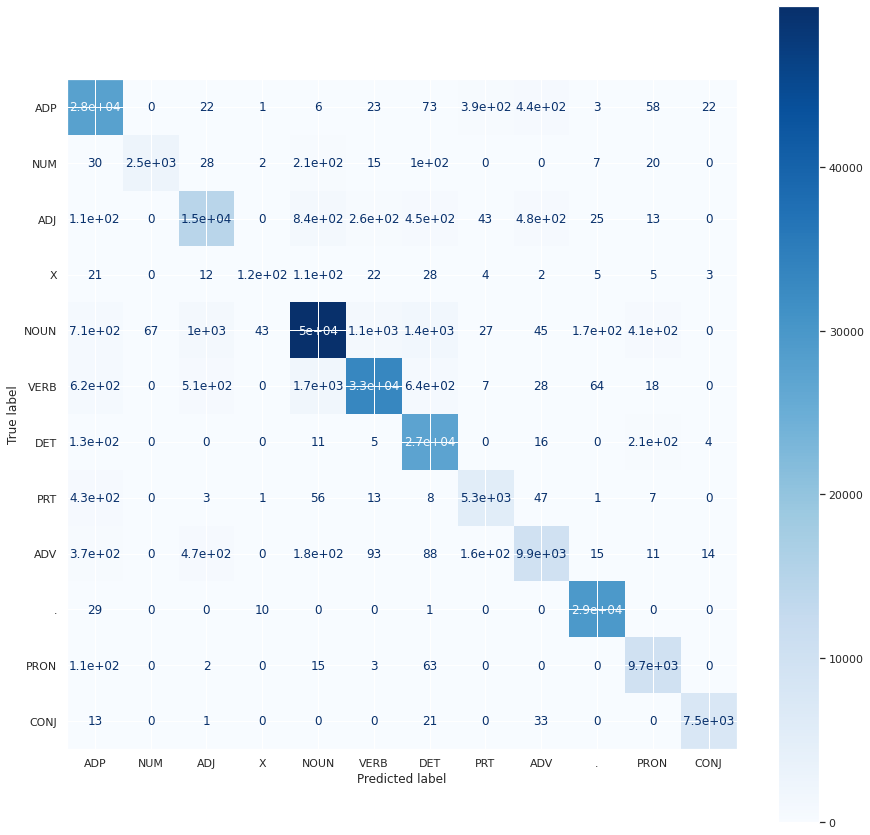




#################### Analysis ####################
accuracy:  0.9349924760808358
Precision: 93.55%, Recall: 93.50%,    f1: 93.46%
f0.5: 93.50%
f2: 93.47%
Final Precision:93.55%,     Recall: 93.50%,   f1:93.46%,    f0.5:93.50%,    f2:93.47%


In [ ]:
sn.set(rc={'figure.figsize': (12, 12)})
plt.rcParams["figure.figsize"] = (15,15)

hmm = HMM()

kfold = KFold(n_splits=KFOLD, shuffle=True,
                random_state=42)  # set random_state=None later setting seed to reproduce result over multiple calls.

for fold, (train_idx, test_idx) in enumerate(kfold.split(hmm.tagged_sents)):
    print(f'\n\n#####       Running fold number: {fold + 1}       #####')
    hmm.train_sents = map(hmm.tagged_sents.__getitem__, train_idx)
    hmm.test_sents = map(hmm.tagged_sents.__getitem__, test_idx)

    # if TEST:
    #     hmm.test_sents = test_sentence

    hmm.train()
    prediction = hmm.test()
    hmm.analysis(prediction)
    
    break


count = hmm.pos_info[COUNT_KEY]
print(f'Final Precision:{100*hmm.pos_info["P"]/count:.2f}%,     Recall: {100*hmm.pos_info["R"]/count:.2f}%,   '
        f'f1:{100*hmm.pos_info["f1"]/count:.2f}%,    f0.5:{100*hmm.pos_info["f0.5"]/count:.2f}%,    f2:{100*hmm.pos_info["f2"]/count:.2f}%')

# Dump

In [ ]:
import pickle
hmm.tagged_sents = None
hmm.train_sents = None
hmm.test_sents = None

with open('hmm_object.pickle', 'wb') as fid:
    pickle.dump(hmm, fid)

# Testing

In [ ]:
import pickle
TEST = True
KFOLD = 5
COUNT_KEY = 'count'
START_TAG = '^'
END_TAG = '.'
EPSILON = 1e-5
NO_WORD = '<NAW>'

In [ ]:
hmm = None
with open('hmm_object.pickle', 'rb') as fid:
    hmm = pickle.load(fid)

In [ ]:
# hmm.test_sents = [[('If', 'ADP'), ('this', 'DET'), ('choice', 'NOUN'), ('is', 'VERB'), ('less', 'ADV'), ('exciting', 'ADJ'), ('than', 'ADP'), ('New', 'ADJ'), ('York', 'NOUN'), ('Democrats', 'NOUN'), ('may', 'VERB'), ('wish', 'VERB'), (',', '.'), ('it', 'PRON'), ('nevertheless', 'ADV'), ('must', 'VERB'), ('be', 'VERB'), ('made', 'VERB'), ('.', '.')]]
# hmm.test_sents = [[('I','PRON'),('went','VERB'),('to','ADP'),('the','DET'),('bank','NOUN'),('to','PRT'),('withdraw','VERB'),('some','DET'),('money','NOUN'),('.','.')]]
hmm.test_sents = [[('I','t'),('went','t'),('to','t'),('the','t'),('bank','t'),('to','t'),('withdraw','t'),('some','t'),('money','t'),('.','t')]]
prediction = hmm.test()

word,	 tag,	 pred_tag
i	 t	 PRON
went	 t	 VERB
to	 t	 ADP
the	 t	 DET
bank	 t	 NOUN
to	 t	 PRT
withdraw	 t	 VERB
some	 t	 DET
money	 t	 NOUN
.	 t	 .
##############


In [ ]:
# hmm.test_sents = [[('I','PRON'),('went','VERB'),('to','ADP'),('the','DET'),('bank','NOUN'),('to','PRT'),('have','VERB'),('a','DET'),('bath','NOUN'),('in','ADP'),('the','DET'),('river','NOUN'),('.','.')]]
hmm.test_sents = [[('I','t'),('went','t'),('to','t'),('the','t'),('bank','t'),('to','t'),('have','t'),('a','t'),('bath','t'),('in','t'),('the','t'),('river','t'),('.','t')]]
prediction = hmm.test()

word,	 tag,	 pred_tag
i	 t	 PRON
went	 t	 VERB
to	 t	 ADP
the	 t	 DET
bank	 t	 NOUN
to	 t	 PRT
have	 t	 VERB
a	 t	 DET
bath	 t	 NOUN
in	 t	 ADP
the	 t	 DET
river	 t	 NOUN
.	 t	 .
##############


In [ ]:
# prediction = hmm.test()
# hmm.analysis(prediction)

In [ ]:
# hmm.test_sents = [[('The','DET'),('school','NOUN'),('is','VERB'),('seeing','VERB'),('return','NOUN'),('of','ADP'),('students','NOUN'),('.','.')]]
hmm.test_sents = [[('The','t'),('school','t'),('is','t'),('seeing','t'),('return','t'),('of','t'),('students','t'),('.','t')]]
prediction = hmm.test()

In [ ]:
# hmm.test_sents = [[('The','DET'),('school','NOUN'),('of','ADP'),('fish','NOUN'),('is','VERB'),('swimming','VERB'),('past','ADP'),('the','DET'),('island','NOUN'),('.','.')]]
hmm.test_sents = [[('The','t'),('school','t'),('of','t'),('fish','t'),('is','t'),('swimming','t'),('past','t'),('the','t'),('island','t'),('.','t')]]
prediction = hmm.test()

In [ ]:
hmm.test_sents = [[('tell','t'),('me','t'),('how','t'),('to','t'),('go','t'),('to','t'),('london','t'),('.','t')]]
prediction = hmm.test()

word,	 tag,	 pred_tag
tell	 t	 VERB
me	 t	 PRON
how	 t	 ADV
to	 t	 PRT
go	 t	 VERB
to	 t	 ADP
london	 t	 NOUN
.	 t	 .
##############
